In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from htc.context.manipulated_datasets.utils import compare_performance
from htc.context.neighbour.find_normalized_neighbour_matrix import find_normalized_neighbour_matrix
from htc.context.settings_context import settings_context
from htc.fonts.set_font import set_font
from htc.models.data.DataSpecification import DataSpecification
from htc.models.image.DatasetImage import DatasetImage
from htc.settings_seg import settings_seg
from htc.utils.Config import Config
from htc.utils.helper_functions import sort_labels, sort_labels_cm

set_font(16)

In [2]:
# Neighbor matrix
specs = DataSpecification("pigs_semantic-only_5foldsV2.json")
specs.activate_test_set()
config = Config({"input/no_features": True, "label_mapping": settings_seg.label_mapping})
dataset = DatasetImage(specs.paths("test"), train=False, config=config)

number_of_classes = len(settings_seg.label_mapping)
labels = sort_labels(settings_seg.labels)
labels_mpl = [settings_context.labels_paper_renaming.get(l, l).replace("<br>", "\n") for l in labels]
normalized_neighbor_matrix = find_normalized_neighbour_matrix(dataset, number_of_classes) * 100
normalized_neighbor_matrix = sort_labels_cm(
    normalized_neighbor_matrix,
    cm_order=settings_seg.labels,
    target_order=labels,
)
normalized_neighbor_matrix = normalized_neighbor_matrix.T

# Removal CM
experiment_name = "organ_removal_0"
experiment_dir = (
    settings_context.results_dir
    / "neighbour_analysis"
    / experiment_name
    / "image/2022-02-03_22-58-44_generated_default_model_comparison"
)
confusion_matrix, column_names = compare_performance(experiment_name=experiment_name, experiment_dir=experiment_dir)

labels = [l for l in settings_seg.label_colors_paper.keys() if l in column_names]
labels = sort_labels(labels)
confusion_matrix = sort_labels_cm(confusion_matrix, cm_order=column_names, target_order=labels)

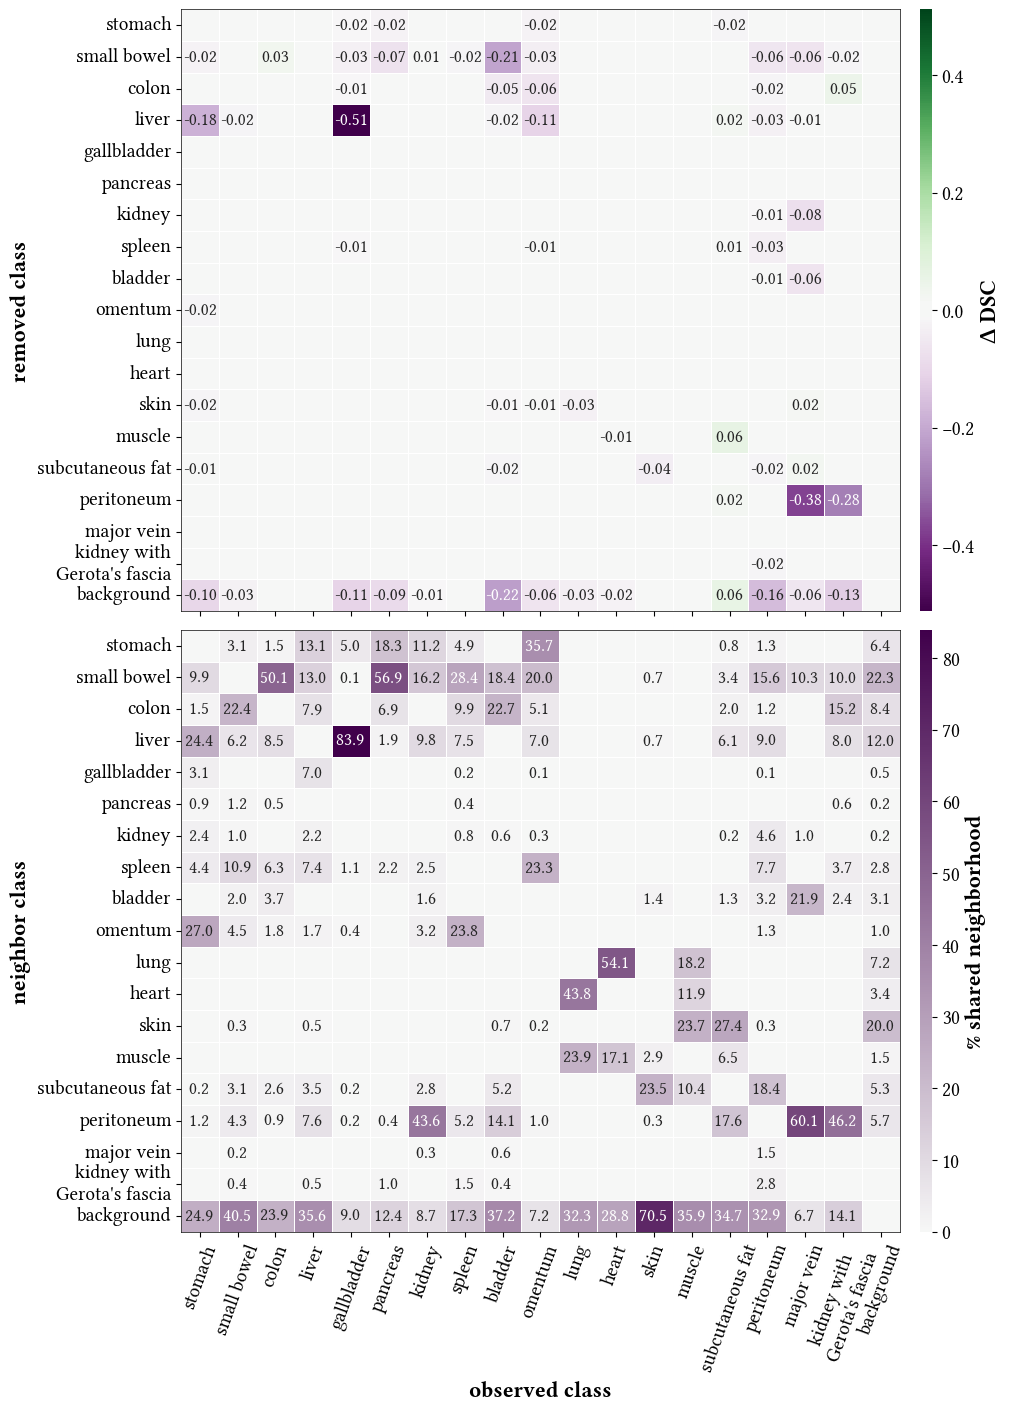

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14), sharex=True, constrained_layout=True)

# Removal CM
# Colorbar with greater diverging middle: https://stackoverflow.com/a/59273964
max_value = confusion_matrix.abs().max().item()
hide_threshold = 0.01
p = [-max_value, -hide_threshold, hide_threshold, max_value]
f = lambda x: np.interp(x, p, [0, 0.5, 0.5, 1])
cbar_resolution = 1000
cmap = LinearSegmentedColormap.from_list(
    "map_white",
    list(
        zip(
            np.linspace(0, 1, num=cbar_resolution),
            plt.colormaps[settings_context.cmap_diverging](f(np.linspace(min(p), max(p), num=cbar_resolution))),
        )
    ),
)

# Hide small numbers
text = np.vectorize(lambda x: "" if abs(x) < hide_threshold else f"{x:.2f}")(confusion_matrix)
label_names = [settings_context.labels_paper_renaming.get(l, l).replace("<br>", "\n") for l in labels]

sns.heatmap(
    confusion_matrix,
    annot=text,
    linewidths=0.5,
    cmap=cmap,
    center=0,
    vmin=-confusion_matrix.abs().max(),
    vmax=confusion_matrix.abs().max(),
    annot_kws={"size": 12.5},
    fmt="s",
    xticklabels=label_names,
    yticklabels=label_names,
    cbar_kws={"aspect": 50, "pad": 0.02, "location": "right"},
    ax=ax1,
)

ax1.set_ylabel("removed class", loc="center", fontweight="bold")

# Make frame visible
for _, spine in ax1.spines.items():
    spine.set_linewidth(0.5)
    spine.set_visible(True)

cbar = ax1.collections[0].colorbar
cbar.set_label("Δ DSC", fontweight="bold")

# Neighbor Matrix
text = np.vectorize(lambda x: "" if x < 0.1 else f"{x:.1f} ")(normalized_neighbor_matrix)
res = sns.heatmap(
    normalized_neighbor_matrix,
    annot=text,
    fmt="s",
    linewidths=0.5,
    xticklabels=labels_mpl,
    yticklabels=labels_mpl,
    annot_kws={"size": 12.5},
    cmap=LinearSegmentedColormap.from_list(
        "neighbor",
        [
            # Lower part of the diverging colorbar
            plt.colormaps.get_cmap(settings_context.cmap_diverging)(0.5),
            plt.colormaps.get_cmap(settings_context.cmap_diverging)(0),
        ],
    ),
    cbar_kws={"aspect": 50, "pad": 0.02, "location": "right"},
    ax=ax2,
)

# Make frame visible
for _, spine in ax2.spines.items():
    spine.set_linewidth(0.5)
    spine.set_visible(True)

cbar = ax2.collections[0].colorbar
cbar.set_label("% shared neighborhood", fontweight="bold")
ax2.set_ylabel("neighbor class", loc="center", fontweight="bold")

for t in ax2.xaxis.get_ticklabels():
    t.set_rotation(70)

ax2.set_xlabel("observed class", fontweight="bold")

fig.savefig(settings_context.paper_extended_dir / "neighbor_removal.pdf", bbox_inches="tight")